In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

import random

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
class Board:

    def __init__(self, player=1):
        self.board = [0, 0, 0, 0, 0, 0, 0, 0, 0]
        self.player = player


    def __repr__(self):
        return str(self.board)

    def get_winner(self):
        # tic tac toe
        for i in range(3):
            if self.board[i] == self.board[i + 3] == self.board[i + 6] != 0:
                return self.board[i]

            if self.board[i * 3] == self.board[i * 3 + 1] == self.board[i * 3 + 2] != 0:
                return self.board[i * 3]

        if self.board[0] == self.board[4] == self.board[8] != 0:
            return self.board[0]

        if self.board[2] == self.board[4] == self.board[6] != 0:
            return self.board[2]

        if all([x != 0 for x in self.board]):
            return 0

        return None

    def do_move(self, i):
        self.board[i] = self.player
        self.player = -self.player

    def get_available_moves(self):
        return set([i for i, x in enumerate(self.board) if x == 0])

    def copy(self):
        b = Board(self.player)
        b.board = self.board.copy()
        return b

def play(ag):
    ag.eval()

    b = Board()
    h = []
    while True:

        w = b.get_winner()
        if w is not None:
            return h, w

        if b.player == 1:
            with torch.no_grad():
                x = torch.Tensor(b.board)
                o, _ = ag(x)
                y = o.exp().argmax().item()
                h.append((b.copy(), y))
                if y not in b.get_available_moves():
                    return h, -1
                b.do_move(y)
        else:
            b.do_move(random.choice(list(b.get_available_moves())))


def test(ag, n=100):
    wins = 0
    draws = 0
    loses = 0
    for _ in range(n):
        h, w = play(ag)
        if w == 1:
            wins += 1
        elif w == 0:
            draws += 1
        else:
            loses += 1
    return wins / n, draws / n, loses / n

  0%|          | 0/4000 [00:00<?, ?it/s]

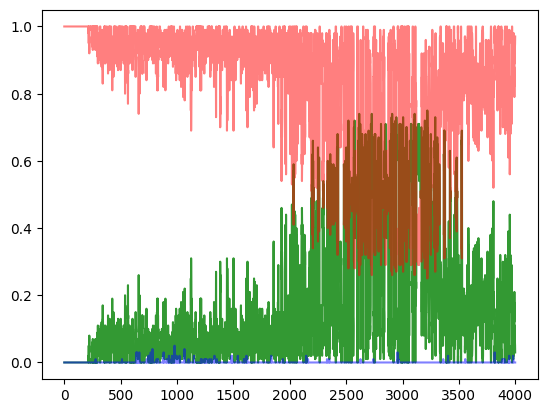

In [21]:
class Agent(nn.Module):
    def __init__(self):
        super(Agent, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(9, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64)
        )

        self.pe = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 9),
            nn.LogSoftmax(dim=-1)
        )

        self.ve = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        h = self.seq(x)
        return self.pe(h), self.ve(h)



ag = Agent()

optimizer = optim.Adam(ag.parameters(), lr=0.0001)
crit1 = nn.NLLLoss(reduction='none')
crit2 = nn.MSELoss()
wh = []
dh = []
lh = []


for _ in tqdm(range(4000)):
    w, d, l = test(ag)
    wh.append(w)
    dh.append(d)
    lh.append(l)

    h, r = play(ag)
    b, a = zip(*h)
    x = torch.Tensor([x.board for x in b])
    y = torch.LongTensor(a)
    r = torch.Tensor([r] * len(h))

    optimizer.zero_grad()
    ag.train()
    o, v = ag(x)
    loss = torch.mean(crit1(o, y) * r) + crit2(v.squeeze(1), r)
    loss.backward()
    optimizer.step()



plt.plot(wh, c='g', alpha=0.8)
plt.plot(dh, c='b', alpha=0.5)
plt.plot(lh, c='r', alpha=0.5)
plt.show()
